# Multi-Level Models (Hierarchical Models)

So far, we haven't considered the probability distribution of the fitting parameters $D_0,k_1,k_2$, and $k_3$. But to use a hierarchical model to combine our inference from different patch data and allow us to model our serum estradiol concentration, we will need to introduce hyperparameters that connect different studies. This way, our fitting parameters are given a "probabilistic specification" in terms of hyperparameters that are common for all. In our case, the hyperparameters would be the parameters of the distribution ([hyperprior](https://en.wikipedia.org/wiki/Hyperprior)) we choose to use in order to model our fitting parameters.

# Before and After Patch Removal

We can see from [3_Steady-State_Multi-Dose_3-Compartment](3_Steady-State_Multi-Dose_3-Compartment) that the decay after patch removal is not captured when the serum Estradiol solution didn't consider measurement after patch removal as a separate process.

After patch removal, the estradiol concentration within the depot $d_0$ (and thus $D(t_0)$) is zero.

We then [evolve](https://discord.com/channels/438306949285806082/1201973466845151362/1206123175331627029) our solution $E_2(t)$ with the initial condition at patch removal $t_{\rm rem}$ to be given by $A_{\rm eff}(t_{\rm rem})$ and $E_2(t_{\rm rem})$. i.e., we have for $E_2(t)$ after $t_{\rm rem}$

$$E_2^{t_{\rm rem}}(t)=\frac{k_2A_{\rm eff}(t_{\rm rem})}{k_2-k_3}\left[-\frac{e^{-k_2(t-T\operatorname{floor}(t/T))}}{1-e^{-k_2T}}+\frac{e^{-k_3(t-T\operatorname{floor}(t/T))}}{1-e^{-k_3T}}\right]+E_2(t_{\rm rem})\frac{e^{-k_3(t-T\operatorname{floor}(t/T))}}{1-e^{-k_3T}}.$$

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
#import theano.tensor as tt    # https://discourse.pymc.io/t/defining-an-array-to-store-rv-before-they-are-introduced-in-the-likelihood/1373

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import jax
jax.default_backend()

'gpu'

In [11]:
# import and visualize data

MylanTDPDays100 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_100mcg.csv', delimiter=',', skip_header=True)
MylanTDPDays50 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_50mcg.csv', delimiter=',', skip_header=True)
MylanTDPDays25 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_25mcg.csv', delimiter=',', skip_header=True)

H2003aN30Estradot100 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_100mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot50 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_50mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot37_5 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_37.5mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot25 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_25mcg.csv', delimiter=',', skip_header=True)

H2003bN11Estradot100 = np.genfromtxt('Data/Hossain2003b_Estradot_n11/H2003b_Estradot_n11_100mcg.csv', delimiter=',', skip_header=True)
H2003bN11Estradot50 = np.genfromtxt('Data/Hossain2003b_Estradot_n11/H2003b_Estradot_n11_50mcg.csv', delimiter=',', skip_header=True)

# exclude n = 30 study from H2003b due to the initial measurement being higher than the second measurement
#H2003bN30Estradot50 = np.genfromtxt('Data/Hossain2003b_Estradot_n30/H2003b_Estradot_n30_50mcg.csv', delimiter=',', skip_header=True)

# convert Mylan data from days to hrs, Estradot data is already in hrs
# https://stackoverflow.com/questions/10394659/how-to-add-a-calculated-computed-column-in-numpy

MylanTDP100 = np.vstack((MylanTDPDays100[:,0]*24, MylanTDPDays100[:,1])).T
MylanTDP50 = np.vstack((MylanTDPDays50[:,0]*24, MylanTDPDays50[:,1])).T
MylanTDP25 = np.vstack((MylanTDPDays25[:,0]*24, MylanTDPDays25[:,1])).T

In [77]:
def E2(t, d0, k1, k2, k3):
    summation = 0
    innerFunc1 = pm.math.exp(-k1 * t) / ((k1 - k2) * (k1 - k3))
    innerFunc2 = pm.math.exp(-k2 * t) / ((k1 - k2) * (k2 - k3))
    innerFunc3 = pm.math.exp(-k3 * t) / ((k1 - k3) * (k2 - k3))
    summation = d0 * (innerFunc1 - innerFunc2 + innerFunc3)
    return k1 * k2 * summation

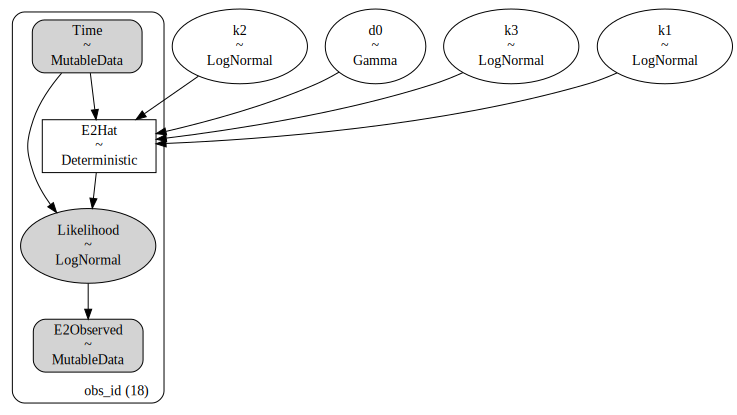

In [99]:
# https://github.com/obscode/FlyingCircus/blob/master/MoreNotebooks/ModelFitting/Pymc.ipynb
# https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html#deterministic-transforms

# LaTeX needs to be treated as raw string literal for az to work, https://lightrun.com/answers/arviz-devs-arviz-latex-label-compatibility-issues-while-using-bokeh-as-backend, https://stackoverflow.com/questions/2081640/what-exactly-do-u-and-r-string-prefixes-do-and-what-are-raw-string-literals
# better not use LaTeX for variable names due to issues with plotting via az.plot_ppc

# https://github.com/pymc-devs/pymc-examples/blob/main/examples/generalized_linear_models/multilevel_modeling.ipynb

Mylan100Model = pm.Model()

with Mylan100Model:
    Mylan100TimeData = pm.MutableData("Time", MylanTDP100[:,0], dims="obs_id")
    Mylan100Data = pm.MutableData("E2Observed", MylanTDP100[:,1], dims="obs_id")
    #sigma = pm.InverseGamma("sigma", alpha=1, beta=4)

    # priors
    d0 = pm.Gamma("d0", alpha=3, beta=50)    # https://homepage.divms.uiowa.edu/~mbognar/applets/gamma.html, based on https://discord.com/channels/438306949285806082/1201973466845151362/1201999987731599462
    #Aeff0 = pm.Gamma("Aeff0", alpha=1, beta=50)
    #E20 = pm.Gamma("E20", alpha=1, beta=100)
    k1 = pm.LogNormal("k1", mu=1/(100/24), sigma=0.1)    # https://homepage.divms.uiowa.edu/~mbognar/applets/lognormal.html
    k2 = pm.LogNormal("k2", mu=0.15, sigma=1)
    k3 = pm.LogNormal("k3", mu=1/37, sigma=0.1)    # https://homepage.divms.uiowa.edu/~mbognar/applets/lognormal.html

    # likelihood, https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/GLM_linear.html
    E2Hat = pm.Deterministic("E2Hat", E2(Mylan100TimeData, d0, k1, k2, k3), dims="obs_id")
    Likelihood = pm.LogNormal("Likelihood", mu = E2Hat, observed = Mylan100Data,
                              sigma=pm.math.sqrt(Mylan100TimeData), dims="obs_id")

# visualize the model
# https://github.com/pymc-devs/pymc-examples/blob/main/examples/generalized_linear_models/GLM-simpsons-paradox.ipynb
pm.model_to_graphviz(Mylan100Model)

In [100]:
with Mylan100Model:
    sampleMylan100 = pm.sample(5000, tune=1000)

az.summary(sampleMylan100)    #  see https://python.arviz.org/en/latest/api/diagnostics.html

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d0, k1, k2, k3]
/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1649 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 549 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` o

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d0,0.060,0.026,0.023,0.094,0.010,0.008,9.0,24.0,2.48
k1,1.284,0.083,1.125,1.407,0.027,0.020,10.0,27.0,1.90
k2,1.620,1.336,0.066,2.230,0.189,0.135,11.0,27.0,1.95
k3,1.100,0.091,0.952,1.229,0.037,0.028,8.0,27.0,2.12
E2Hat[0],0.000,0.000,-0.000,0.000,0.000,0.000,5.0,26.0,3.07
E2Hat[1],0.017,0.007,0.005,0.025,0.003,0.002,9.0,27.0,2.21
E2Hat[2],0.006,0.002,0.001,0.009,0.000,0.000,14.0,25.0,2.15
E2Hat[3],0.000,0.001,0.000,0.001,0.000,0.000,11.0,24.0,2.11
E2Hat[4],0.000,0.000,0.000,0.000,0.000,0.000,9.0,6.0,1.93
E2Hat[5],0.000,0.000,0.000,0.000,0.000,0.000,7.0,27.0,1.92


Sampling: [Likelihood]


/home/ubuntu/venv310/lib/python3.10/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/home/ubuntu/venv310/lib/python3.10/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


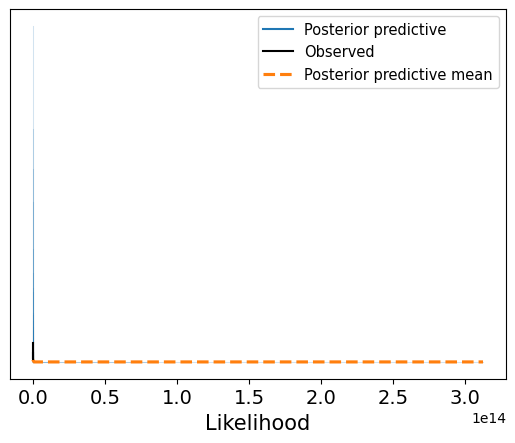

In [102]:
# https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)
with Mylan100Model:
    pm.sample_posterior_predictive(sampleMylan100, extend_inferencedata=True, random_seed=rng)
az.plot_ppc(sampleMylan100, num_pp_samples=100);

In [35]:
# obtain Maximum A-Posteriori, https://discord.com/channels/438306949285806082/1201973466845151362/1202106780339937310
# https://stackoverflow.com/a/47803291
# https://discourse.pymc.io/t/evaluating-log-likelihood-using-estimates-from-find-map-results/4403: ...
# ... find_MAP optimized free parameters on the unbounded scale (in many cases it is also desired as you dont need to specify the boundary of parameters), see a related discussion https://github.com/pymc-devs/pymc3/issues/2545.
# although from https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.find_MAP.html#pymc.find_MAP: Older code examples used find_MAP to initialize the NUTS sampler, but this is not an effective way of choosing starting values for sampling. As a result, we have greatly enhanced the initialization of NUTS and wrapped it inside pymc.sample() and you should thus avoid this method.

#with Mylan100Model:
#    map_estimate = pm.find_MAP()

# it's better to extract inference using az since pymc.sampling returns arviz.InferenceData, https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sampling.forward.sample_posterior_predictive.html#pymc.sampling.forward.sample_posterior_predictive
# also evaluating the model using E2Full(t,...) with map_estimate['$d(t_0)$'] ... doesn't work as if we are using np.math

In [42]:
Mylan100Model.free_RVs

[$d(t_0)$ ~ Gamma(3, f()),
 $A_{\rm eff}(t_0)$ ~ Gamma(1, f()),
 $E_2(t_0)$ ~ Gamma(1, f()),
 $k_1$ ~ LogNormal(0.24, 0.1),
 $k_2$ ~ Gamma(1, f()),
 $k_3$ ~ LogNormal(0.027, 0.1)]

In [12]:
# extracting posterior, https://python.arviz.org/en/latest/getting_started/WorkingWithInferenceData.html
Mylan100BeforePost = sampleMylan100.posterior
Mylan100BeforePost

<xarray.Dataset>
Dimensions:             (chain: 4, draw: 5000)
Coordinates:
  * chain               (chain) int64 0 1 2 3
  * draw                (draw) int64 0 1 2 3 4 5 ... 4995 4996 4997 4998 4999
Data variables:
    $d(t_0)$            (chain, draw) float64 0.05001 0.05076 ... 0.06559
    $A_{\rm eff}(t_0)$  (chain, draw) float64 0.0142 0.004233 ... 0.02175
    $E_2(t_0)$          (chain, draw) float64 0.01931 0.0382 ... 0.02114
    $k_1$               (chain, draw) float64 1.376 1.428 1.443 ... 1.236 1.3
    $k_2$               (chain, draw) float64 0.1737 0.6339 ... 0.4206 1.624
    $k_3$               (chain, draw) float64 0.957 0.9518 ... 0.9183 0.9468
Attributes:
    created_at:                 2024-02-15T02:58:43.604498
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3
    sampling_time:              20.279279232025146
    tuning_steps:               1000

In [15]:
# subset of sampled posterior
SubSetStackedPostMylan100Before = az.extract(Mylan100BeforePost, num_samples=100)
SubSetStackedPostMylan100Before

<xarray.Dataset>
Dimensions:             (sample: 100)
Coordinates:
  * sample              (sample) object MultiIndex
  * chain               (sample) int64 0 2 2 1 0 2 2 3 2 0 ... 2 2 0 3 2 0 2 1 3
  * draw                (sample) int64 2215 4330 1770 3979 ... 668 480 1702 2601
Data variables:
    $d(t_0)$            (sample) float64 0.06646 0.08568 ... 0.06337 0.1132
    $A_{\rm eff}(t_0)$  (sample) float64 0.02371 0.01363 ... 0.004825 0.02315
    $E_2(t_0)$          (sample) float64 0.0004412 0.006787 ... 0.0182 0.001251
    $k_1$               (sample) float64 1.215 1.194 1.219 ... 1.237 1.142 1.232
    $k_2$               (sample) float64 0.0171 0.1731 0.1582 ... 1.597 0.05041
    $k_3$               (sample) float64 0.9456 1.122 0.9648 ... 1.178 0.9807
Attributes:
    created_at:                 2024-02-15T02:58:43.604498
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3
    sampling_time:              20.279279232025146
    tuning_steps:               1000